# MRI to Nissl registration example

This example uses a subset of a serial section nissl dataset.

In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import os
from datetime import datetime

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/Documents/UCLA/emlddmm_bryson/emlddmm/emlddmm.py'>

In [21]:
# maybe I want to use the exvivo, not the atlas. that can be a version 2.
atlas_name = '/home/brysongray/data/Allen_Atlas_vtk/ara_nissl_100.vtk'
label_name = '/home/brysongray/data/Allen_Atlas_vtk/annotation_100.vtk'
target_name = '/home/brysongray/data/MD816_mini/MD816_STIF_mini_v2'
config_file = 'config787small.json'
time = datetime.now().strftime("%Y_%m_%d-%I_%M_%S")
output_dir = '787_small_test_outputs_'+time

In [22]:
# note about downsampling
# atlas is size 50x50x50
# data is size 14.74*3x14.72*3x200 (i.e. 10 micron, downsampled by a factor of 20)

In [23]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[100. 100. 100.]


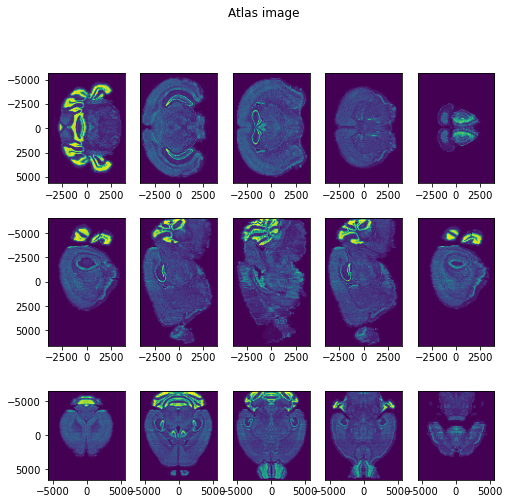

In [24]:
plt.rcParams["figure.figsize"] = (8,8)
# atlas
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')
fig[0].canvas.draw()

In [25]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


Found extension 
loading target images
padding and assembling into 3D volume
[60.   58.88 58.88]


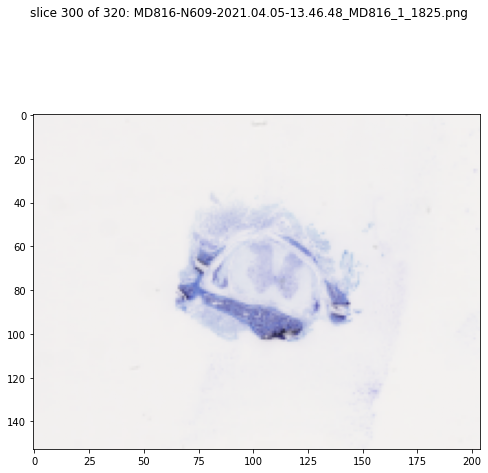

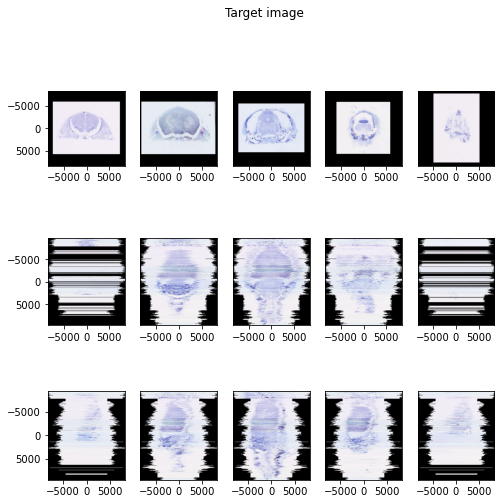

In [26]:
# target
imp.reload(emlddmm)
mindownJ = np.min(np.array(downJs),0)
# use 'down' argument for downsampling while loading into volume
# print('initial downsampling factor: ', mindownJ)
# xJ,J,title,names = emlddmm.read_data(target_name, down= list(mindownJ))
xJ,J,title,names = emlddmm.read_data(target_name)
if 'mask' in names:
    maskind = names.index('mask')
    W0 = J[maskind]
    J = J[np.arange(J.shape[0])!=maskind]    
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)
J /= np.mean(np.abs(J))

fig = emlddmm.draw(J,xJ)#, vmin=0, vmax=1)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

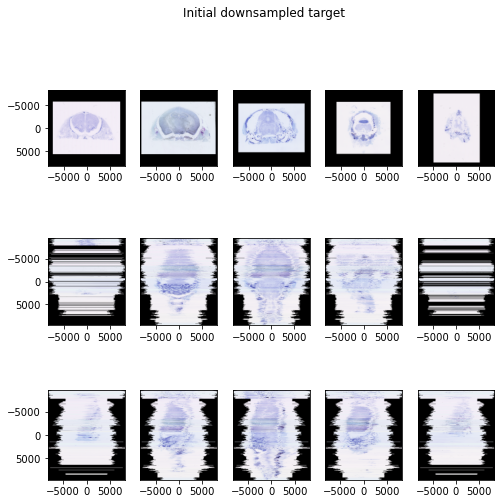

In [11]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()

In [12]:
print(dJ)

[60.0, 117.76000000000022, 117.76000000000204]


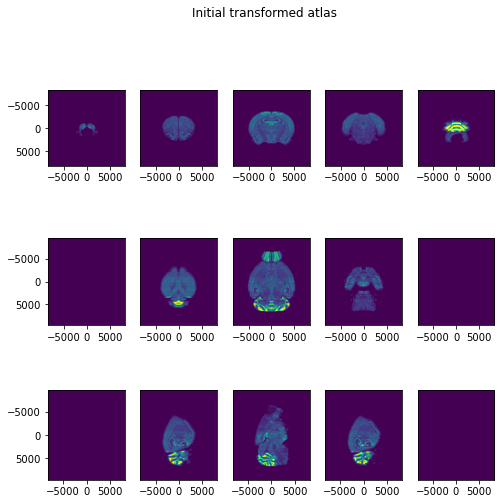

In [13]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)

# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]    

Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')
fig[0].canvas.draw()

In [14]:
# list the config options
for k in config:
    print(f'{k} : {config[k]}')

n_iter : [1000, 500]
downI : [[2, 2, 2], [1, 1, 1]]
downJ : [[1, 2, 2], [1, 1, 1]]
priors : [[0.9, 0.05, 0.05]]
sigmaM : [0.1]
sigmaB : [0.2]
sigmaA : [0.5]
sigmaR : [1000.0]
ev : [0.0005]
eA : [500000.0, 100000.0]
eA2d : [200.0, 50.0]
slice_matching : [1]
update_muA : [0]
update_muB : [0]
muA : [[0.1, 0.1, 0.1]]
muB : [[0.9, 0.9, 0.9]]
update_sigmaM : [0]
update_sigmaA : [0]
update_sigmaB : [0]
order : [3]
n_draw : [50]
n_e_step : [3]
slice_matching_start : [300, 0]
v_start : [10000, 0, 0]
A : [[[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]]


Found 2 scales
dv tensor([300., 300., 300.], device='cuda:0')
a scale is 600.0


/home/brysongray/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Iteration 40, linear oscilating, reducing eA to 450000.0
Finished iteration 40


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 50
Iteration 60, linear oscilating, reducing eA to 405000.0
Finished iteration 60
Iteration 70, linear oscilating, reducing eA to 364500.0
Finished iteration 70
Iteration 80, linear oscilating, reducing eA to 328050.0
Finished iteration 80
Iteration 90, linear oscilating, reducing eA to 295245.0
Finished iteration 90
Iteration 100, linear oscilating, reducing eA to 265720.5


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 100
Iteration 110, linear oscilating, reducing eA to 239148.45
Finished iteration 110
Iteration 120, translation oscilating, reducing eA to 215233.605
Finished iteration 120
Iteration 130, translation oscilating, reducing eA to 193710.2445
Finished iteration 130
Iteration 140, linear oscilating, reducing eA to 174339.22005
Finished iteration 140
Iteration 150, linear oscilating, reducing eA to 156905.298045


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 150
Iteration 160, translation oscilating, reducing eA to 141214.7682405
Finished iteration 160
Iteration 170, translation oscilating, reducing eA to 127093.29141645001
Finished iteration 170
Iteration 180, translation oscilating, reducing eA to 114383.96227480502
Finished iteration 180
Iteration 190, linear oscilating, reducing eA to 102945.56604732452
Finished iteration 190
Iteration 200, translation oscilating, reducing eA to 92651.00944259207


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 200
Iteration 210, linear oscilating, reducing eA to 83385.90849833286
Finished iteration 210
Iteration 220, linear oscilating, reducing eA to 75047.31764849958
Finished iteration 220
Iteration 230, linear oscilating, reducing eA to 67542.58588364962
Finished iteration 230
Iteration 240, linear oscilating, reducing eA to 60788.32729528466
Finished iteration 240
Iteration 250, linear oscilating, reducing eA to 54709.4945657562


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 250
Iteration 260, linear oscilating, reducing eA to 49238.54510918058
Finished iteration 260
Iteration 270, linear oscilating, reducing eA to 44314.690598262525
Finished iteration 270
Iteration 280, translation oscilating, reducing eA to 39883.22153843627
Finished iteration 280
Iteration 290, linear oscilating, reducing eA to 35894.899384592645
Finished iteration 290
Iteration 300, linear oscilating, reducing eA to 32305.40944613338


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 300
Finished iteration 310
Iteration 320, linear oscilating, reducing eA to 29074.868501520043
Finished iteration 320
Iteration 330, linear oscilating, reducing eA to 26167.38165136804
Finished iteration 330
Iteration 340, linear oscilating, reducing eA to 23550.643486231234
Finished iteration 340
Iteration 350, linear oscilating, reducing eA to 21195.57913760811


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 350
Iteration 360, linear oscilating, reducing eA to 19076.0212238473
Finished iteration 360
Iteration 370, linear oscilating, reducing eA to 17168.41910146257
Finished iteration 370
Iteration 380, translation oscilating, reducing eA to 15451.577191316312
Finished iteration 380
Iteration 390, linear oscilating, reducing eA to 13906.419472184682
Finished iteration 390


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 400
Iteration 410, linear oscilating, reducing eA to 12515.777524966214
Finished iteration 410
Iteration 420, linear oscilating, reducing eA to 11264.199772469592
Finished iteration 420
Iteration 430, linear oscilating, reducing eA to 10137.779795222634
Finished iteration 430
Iteration 440, linear oscilating, reducing eA to 9124.00181570037
Finished iteration 440
Iteration 450, linear oscilating, reducing eA to 8211.601634130333


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 450
Iteration 460, linear oscilating, reducing eA to 7390.4414707173
Finished iteration 460
Iteration 470, linear oscilating, reducing eA to 6651.39732364557
Finished iteration 470
Iteration 480, linear oscilating, reducing eA to 5986.257591281013
Finished iteration 480
Iteration 490, linear oscilating, reducing eA to 5387.6318321529125
Finished iteration 490
Iteration 500, linear oscilating, reducing eA to 4848.868648937621


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 500
Iteration 510, linear oscilating, reducing eA to 4363.981784043859
Finished iteration 510
Iteration 520, linear oscilating, reducing eA to 3927.5836056394733
Finished iteration 520
Iteration 530, linear oscilating, reducing eA to 3534.825245075526
Finished iteration 530
Iteration 540, translation oscilating, reducing eA to 3181.342720567973
Finished iteration 540
Iteration 550, linear oscilating, reducing eA to 2863.208448511176


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 550
Iteration 560, linear oscilating, reducing eA to 2576.887603660058
Finished iteration 560
Iteration 570, translation oscilating, reducing eA to 2319.1988432940525
Finished iteration 570
Iteration 580, linear oscilating, reducing eA to 2087.2789589646472
Finished iteration 580
Iteration 590, linear oscilating, reducing eA to 1878.5510630681827
Finished iteration 590
Iteration 600, linear oscilating, reducing eA to 1690.6959567613644


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 600
Iteration 610, linear oscilating, reducing eA to 1521.626361085228
Finished iteration 610
Iteration 620, linear oscilating, reducing eA to 1369.4637249767052
Finished iteration 620
Iteration 630, translation oscilating, reducing eA to 1232.5173524790348
Finished iteration 630
Iteration 640, linear oscilating, reducing eA to 1109.2656172311313
Finished iteration 640
Iteration 650, translation oscilating, reducing eA to 998.3390555080182


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 650
Iteration 660, linear oscilating, reducing eA to 898.5051499572164
Finished iteration 660
Iteration 670, translation oscilating, reducing eA to 808.6546349614948
Finished iteration 670
Iteration 680, linear oscilating, reducing eA to 727.7891714653454
Finished iteration 680
Iteration 690, linear oscilating, reducing eA to 655.0102543188109
Finished iteration 690
Iteration 700, translation oscilating, reducing eA to 589.5092288869298


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 700
Iteration 710, linear oscilating, reducing eA to 530.5583059982368
Finished iteration 710
Iteration 720, translation oscilating, reducing eA to 477.5024753984132
Finished iteration 720
Iteration 730, linear oscilating, reducing eA to 429.75222785857187
Finished iteration 730
Iteration 740, translation oscilating, reducing eA to 386.7770050727147
Finished iteration 740
Iteration 750, linear oscilating, reducing eA to 348.0993045654432


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 750
Iteration 760, linear oscilating, reducing eA to 313.2893741088989
Finished iteration 760
Iteration 770, linear oscilating, reducing eA to 281.96043669800906
Finished iteration 770
Iteration 780, linear oscilating, reducing eA to 253.76439302820816
Finished iteration 780
Iteration 790, linear oscilating, reducing eA to 228.38795372538735
Finished iteration 790
Iteration 800, linear oscilating, reducing eA to 205.54915835284862


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 800
Iteration 810, linear oscilating, reducing eA to 184.99424251756378
Finished iteration 810
Iteration 820, linear oscilating, reducing eA to 166.4948182658074
Finished iteration 820
Iteration 830, linear oscilating, reducing eA to 149.84533643922666
Finished iteration 830
Iteration 840, linear oscilating, reducing eA to 134.86080279530398
Finished iteration 840
Iteration 850, translation oscilating, reducing eA to 121.37472251577358


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 850
Iteration 860, linear oscilating, reducing eA to 109.23725026419623
Finished iteration 860
Iteration 870, translation oscilating, reducing eA to 98.31352523777662
Finished iteration 870
Iteration 880, translation oscilating, reducing eA to 88.48217271399896
Finished iteration 880
Iteration 890, translation oscilating, reducing eA to 79.63395544259907
Finished iteration 890
Iteration 900, linear oscilating, reducing eA to 71.67055989833916


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 900
Iteration 910, linear oscilating, reducing eA to 64.50350390850525
Finished iteration 910
Iteration 920, linear oscilating, reducing eA to 58.05315351765473
Finished iteration 920
Iteration 930, linear oscilating, reducing eA to 52.247838165889256
Finished iteration 930
Iteration 940, linear oscilating, reducing eA to 47.02305434930033
Finished iteration 940
Iteration 950, translation oscilating, reducing eA to 42.3207489143703


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 950
Iteration 960, linear oscilating, reducing eA to 38.08867402293327
Finished iteration 960
Iteration 970, linear oscilating, reducing eA to 34.279806620639945
Finished iteration 970
Iteration 980, linear oscilating, reducing eA to 30.85182595857595
Finished iteration 980
Iteration 990, linear oscilating, reducing eA to 27.766643362718355
Finished iteration 990


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


dv tensor([300., 300., 300.], device='cuda:0')
a scale is 600.0


/home/brysongray/emlddmm/emlddmm.py:87: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Iteration 30, translation oscilating, reducing eA to 90000.0
Finished iteration 30
Iteration 40, linear oscilating, reducing eA to 81000.0
Finished iteration 40
Iteration 50, translation oscilating, reducing eA to 72900.0
Finished iteration 50
Iteration 60, linear oscilating, reducing eA to 65610.0
Finished iteration 60
Iteration 70, linear oscilating, reducing eA to 59049.0
Finished iteration 70
Iteration 80, translation oscilating, reducing eA to 53144.1
Finished iteration 80
Iteration 90, linear oscilating, reducing eA to 47829.69
Finished iteration 90
Iteration 100, translation oscilating, reducing eA to 43046.721000000005
Finished iteration 100
Iteration 110, linear oscilating, reducing eA to 38742.04890000001
Finished iteration 110
Iteration 120, linear oscilating, reducing eA to 34867.84401000001
Finished iteration 120
Iteration 130, translation oscilating, reducing eA to 31381.059609000007
Finished iteration 130
I

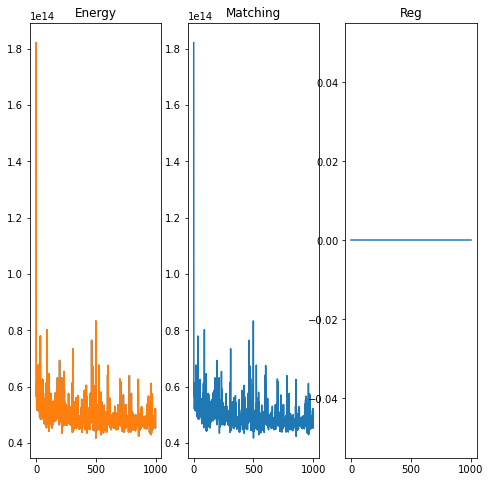

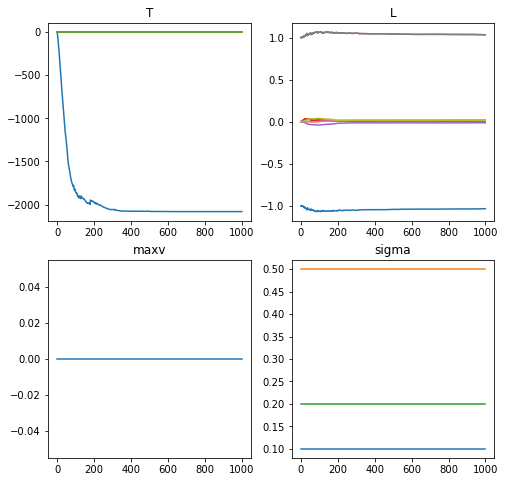

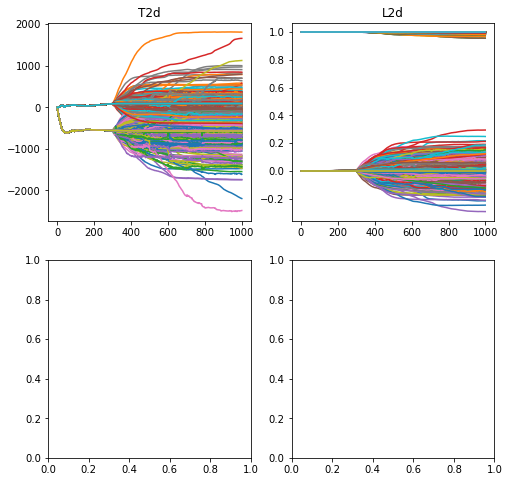

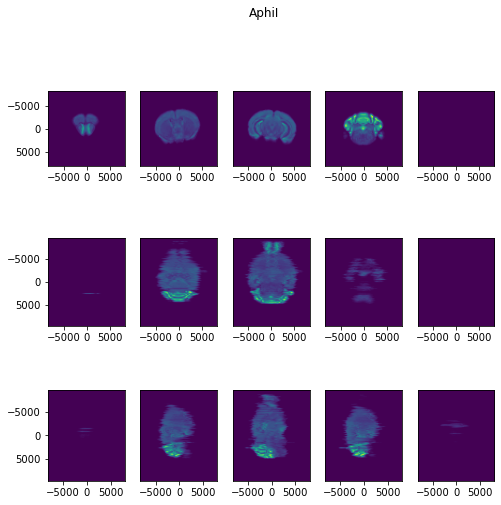

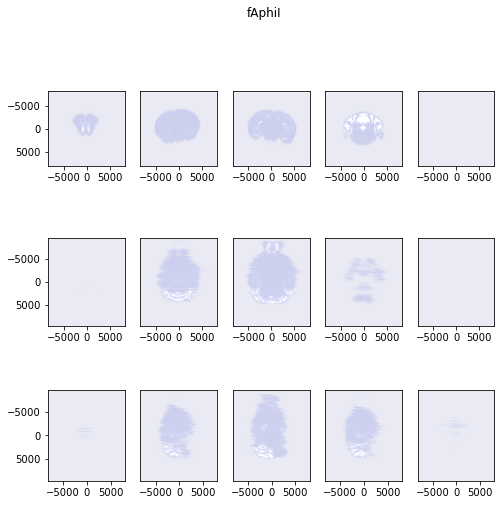

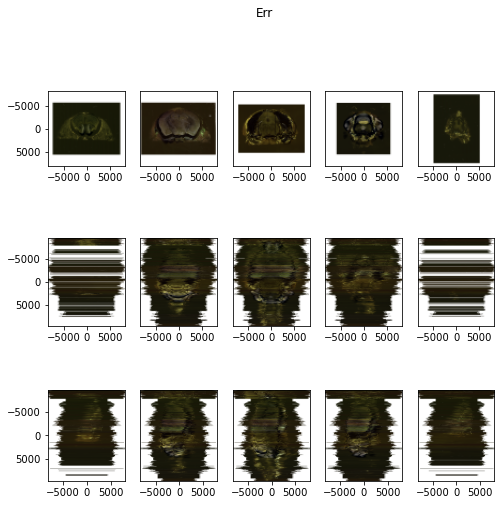

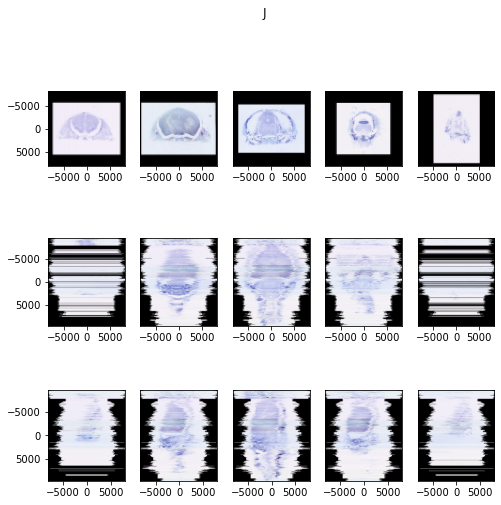

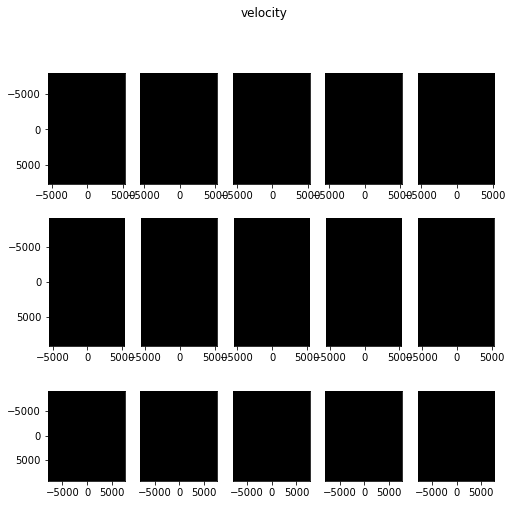

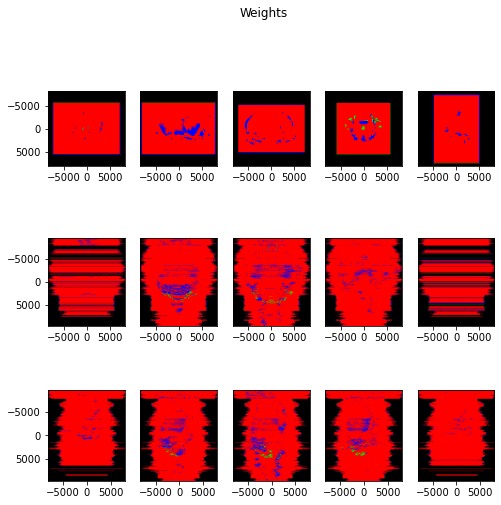

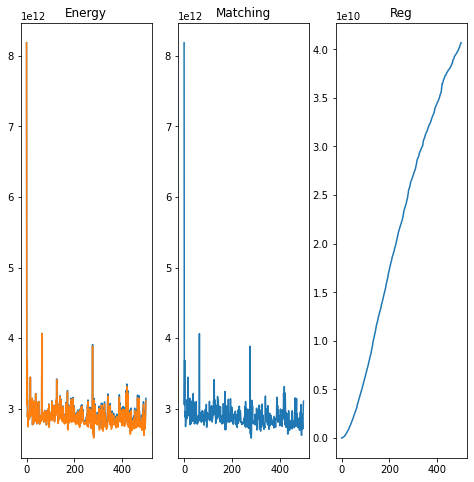

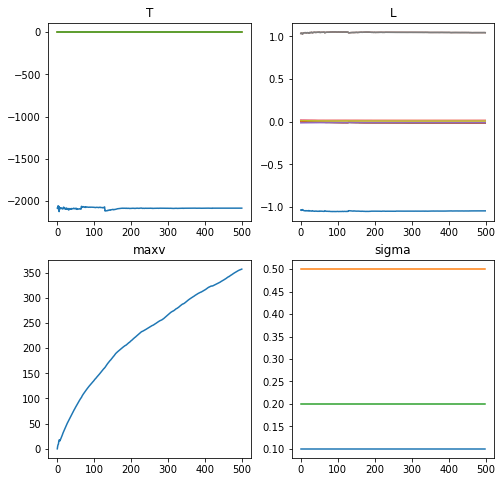

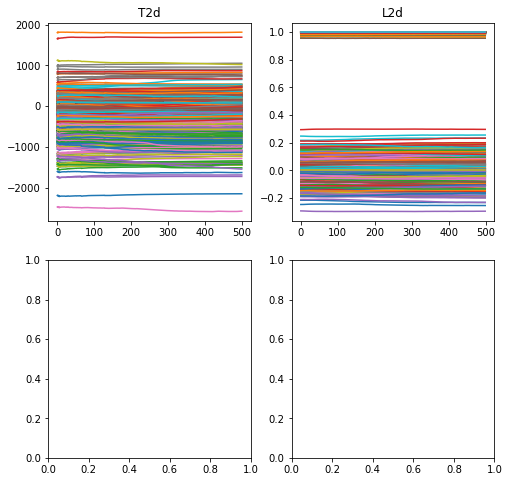

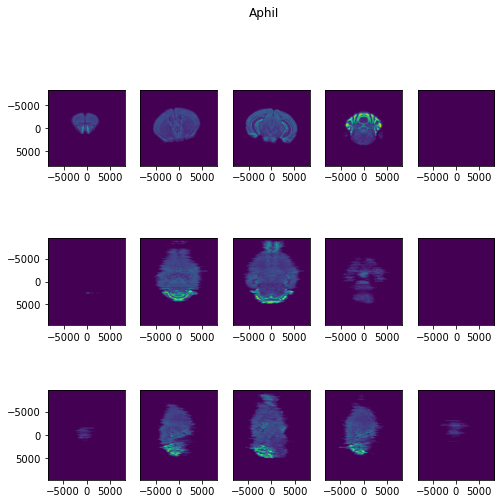

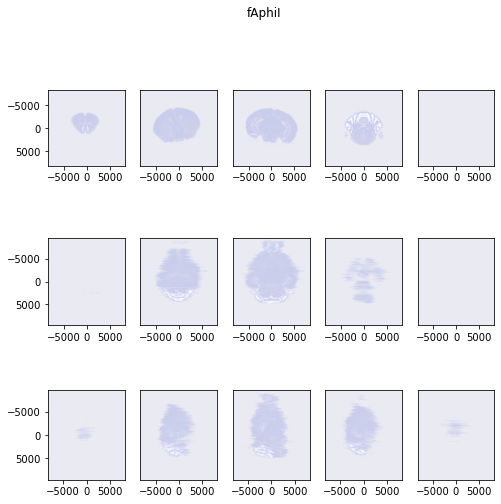

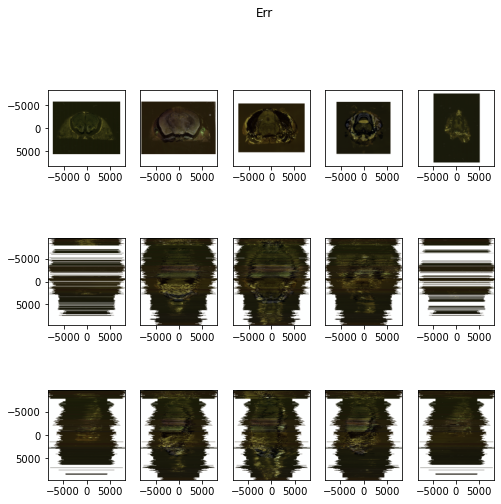

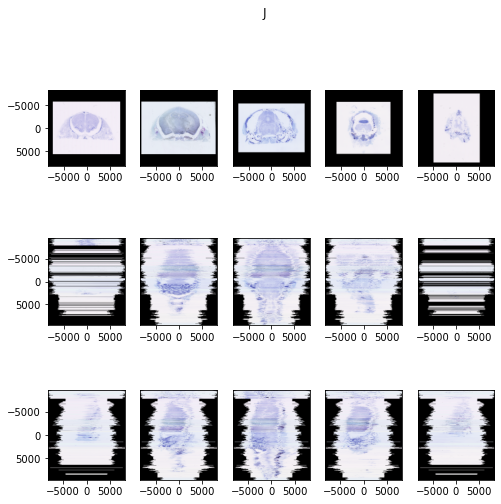

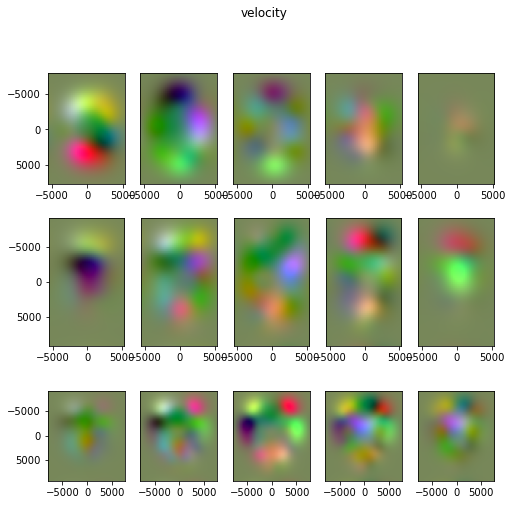

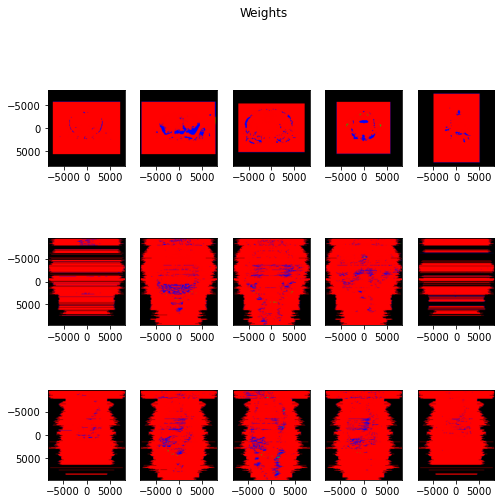

In [15]:
device = 'cuda:0'
# device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [16]:
emlddmm.write_transform_outputs(output_dir,output[-1])

Found extension .vtk
cpu
output dir is 787_small_test_outputs_2022_01_13-03_02_26/qc/
J shape:  torch.Size([3, 320, 141, 144])
AphiI shape:  torch.Size([1, 320, 141, 144])


/home/brysongray/emlddmm/emlddmm.py:1947: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  AphiS = interp(xS,torch.tensor(S,device=device,dtype=dtype),phiiAi,mode='nearest').cpu().numpy()[0]


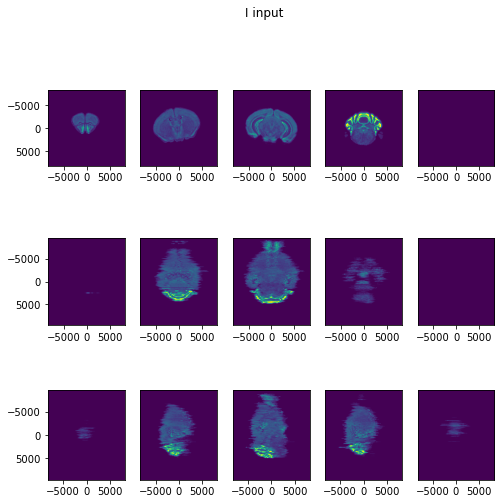

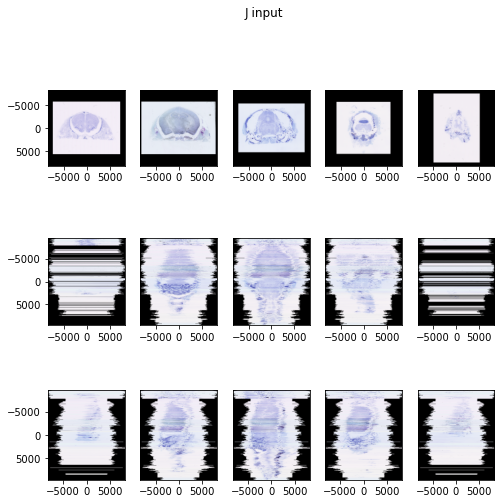

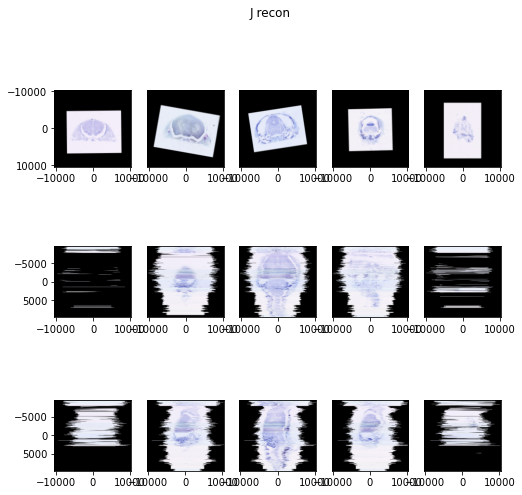

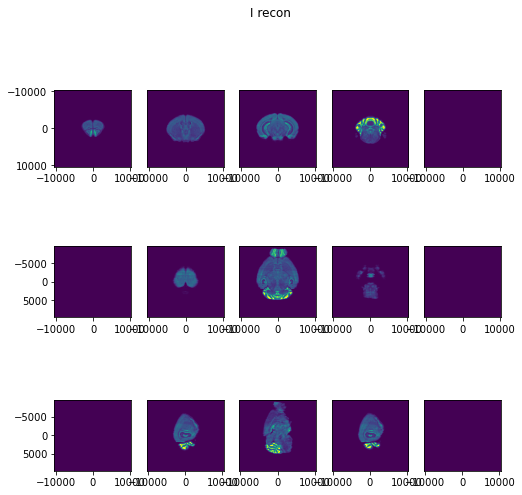

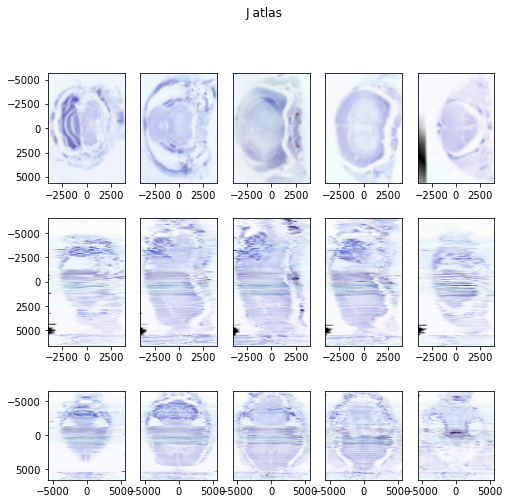

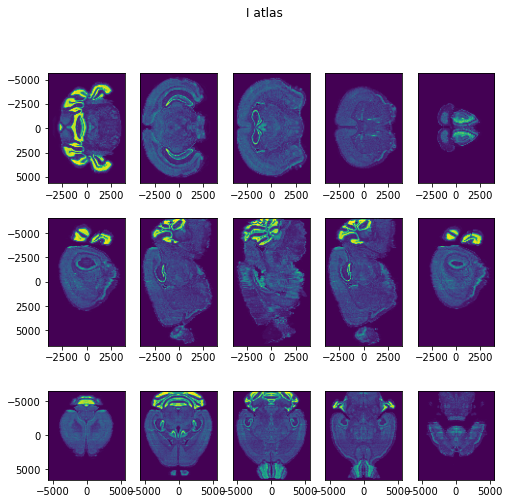

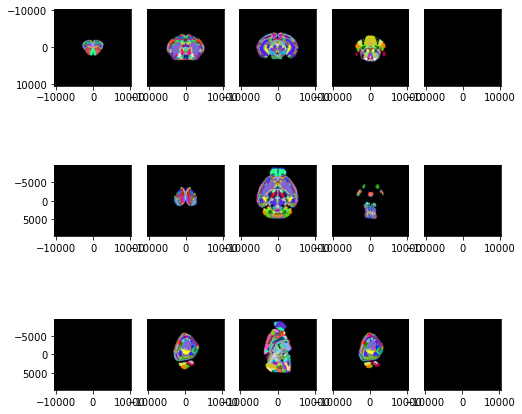

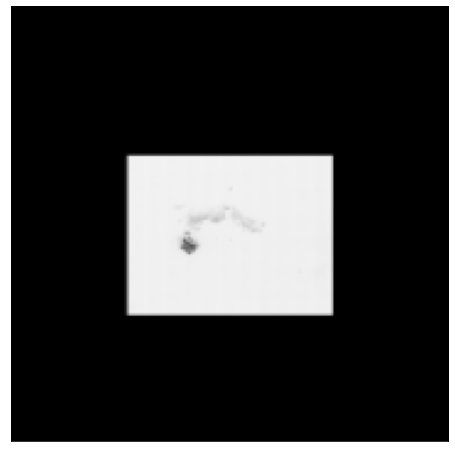

In [17]:
# get labels
imp.reload(emlddmm)
xS,S,title,names = emlddmm.read_data(label_name,endian='l')
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [17]:
# save config used to output
with open(config_file) as f:
    config = json.load(f)
with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f)